<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/02c_depth_phases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [ ]:
!pip install seisbench

This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547

In [ ]:
try:
    import obspy

    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print(
        "Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again."
    )
    exit()

# Determining earthquake depth through depth phase picking

This tutorial shows how to determine the depth of an earthquake by picking teleseismic depth phases. This tutorial focuses on the practical application aspect. For more insights on depth phases and the models, have a look at the associated paper. In this tutorial, we will introduce two interfaces:

- the *classify* interface - determine earthquake depth based on waveforms, P picks, and station-event distances.
- the *DepthFinder* interface - determine earthquake depth from just a preliminar location

**Note:** Some familiarity with obspy and FDSN webservices is helpful for this tutorial but not required.

In [1]:
import seisbench.models as sbm

import matplotlib.pyplot as plt
import numpy as np
import obspy
from tqdm.notebook import tqdm
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import scipy.stats

## *classify* - the low-level interface

To use the *classify* interface, we first need waveforms, picks, a station inventory and an epicenter. We use the FDSN webservice provided by GEOFON to download all this information.

First, we download an event catalog and a station inventory. We select some events from 2010 and all stations from the GE global seismic network.

In [2]:
client = Client("GFZ")

t0 = UTCDateTime("2010-01-01")
t1 = UTCDateTime("2010-12-01")

catalog = client.get_events(
    starttime=t0, endtime=t1, minmagnitude=6.5, mindepth=50, includearrivals=True
)
inv = client.get_stations(network="GE", starttime=t0, endtime=t1, level="CHANNEL")

Let's inspect the catalog.

In [3]:
print(catalog)

8 Event(s) in Catalog:
2010-08-12T11:54:15.780000Z |  -1.201,  -77.315 | 6.93 Mw(mB) | manual
2010-07-23T23:15:10.200000Z |  +6.769, +123.262 | 7.38 Mw(mB) | manual
2010-07-23T22:51:12.380000Z |  +6.496, +123.508 | 7.38 Mw(mB) | manual
2010-07-23T22:08:10.890000Z |  +6.767, +123.472 | 6.81 Mw(Mwp) | manual
2010-06-26T05:30:21.490000Z | -10.544, +161.473 | 6.57 M  | manual
2010-04-11T09:40:29.860000Z | -10.871, +161.153 | 7.09 Mw(mB) | manual
2010-03-14T00:57:46.730000Z |  -1.592, +128.204 | 6.52 Mw(mB) | manual
2010-02-18T01:13:17.550000Z | +42.588, +130.613 | 6.5  Mw(Mwp) | manual


We select one event from out catalog and extract the hypocenter information.

In [4]:
event = catalog[0]

epicenter = (event.preferred_origin().latitude, event.preferred_origin().longitude)

We extract the list of first P arrivals as listed in the catalog. We then download all waveforms from stations in the GE network for which a pick was listed.

In [5]:
p_picks = {}

for pick in event.picks:
    if pick.waveform_id.network_code != "GE":
        continue

    if pick.phase_hint == "P":
        p_picks[pick.waveform_id.id[:-4]] = pick.time

stream = obspy.Stream()
for trace_id, time in tqdm(p_picks.items()):
    stream += client.get_waveforms(*trace_id.split("."), "BH?", time - 100, time + 200)

  0%|          | 0/28 [00:00<?, ?it/s]

/home/muchmej/anaconda3/envs/seisbench/lib/python3.10/site-packages/obspy/io/mseed/headers.py:823: InternalMSEEDWarning: GE_MORC__BHN_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2)
  warnings.warn(_w, InternalMSEEDWarning)
/home/muchmej/anaconda3/envs/seisbench/lib/python3.10/site-packages/obspy/io/mseed/headers.py:823: InternalMSEEDWarning: GE_MORC__BHE_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2)
  warnings.warn(_w, InternalMSEEDWarning)
/home/muchmej/anaconda3/envs/seisbench/lib/python3.10/site-packages/obspy/io/mseed/headers.py:823: InternalMSEEDWarning: GE_MORC__BHZ_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2)
  warnings.warn(_w, InternalMSEEDWarning)


Time to load the depth phase model. We use DepthPhaseTEAM, a multi-station model for depth estimation.

In [6]:
depth_model = sbm.DepthPhaseTEAM.from_pretrained("original")

To estimate the actual depth levels, we use the *classify* function. It will automatically cut out the right segments from the waveforms, determine depth phase arrivals and backproject them onto the depth axis.

In [7]:
depth_output = depth_model.classify(stream, p_picks, inventory=inv, epicenter=epicenter)

In [8]:
print(
    f"Catalog depth:\t{event.preferred_origin().depth / 1e3:.1f}\nInferred depth:\t{depth_output.depth:.1f}"
)

Catalog depth:	202.5
Inferred depth:	205.0


In addition to the depth, the model output contains further details on the prediction.

In [9]:
depth_output.__dict__.keys()

dict_keys(['creator', 'depth', 'depth_levels', 'probabilities', 'avg_probabilities'])

In addition to the depth value, the model provides us with a likelihood curve for the depth of the event. We visualize these likelihoods below. We get one curve for each station (thin lines), the geometric average provides the joint likelihood (bold line). Note that the likelihoods are not normalized.

Text(0.5, 0, 'Likelihood')

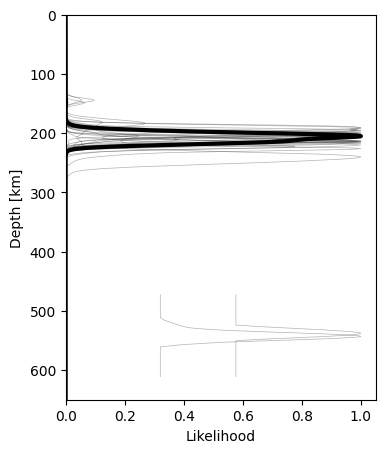

In [10]:
fig = plt.figure(figsize=(4, 5))
ax = fig.add_subplot(111)

for prob in depth_output.probabilities:
    ax.plot(prob / np.nanmax(prob), depth_output.depth_levels, lw=0.5, c="k", alpha=0.3)

avg_prob = scipy.stats.mstats.gmean(
    depth_output.probabilities, nan_policy="omit", axis=0
)
ax.plot(avg_prob / np.nanmax(avg_prob), depth_output.depth_levels, c="k", lw=3, ls="-")

ax.set_ylim(650, 0)
ax.set_xlim(0)
ax.set_ylabel("Depth [km]")
ax.set_xlabel("Likelihood")

## *DepthFinder* - the high-level interface

The *classify* interface provides low-level access to our model. This is the right interface if you have the input data (waveforms, picks, inventory, epicenter) already available. If you only have a catalog of preliminary locations, you can use *DepthFinder*. Depth finder is a multistep process:

- Determine the list of available stations from a list of predefined seismic networks through FDSN. These should usually be high-quality global networks.
- Predict approximate P arrivals using a global 1D travel time model.
- Download waveform segments around these arrivals through FDSN.
- Repick P arrivals around the predicted P arrivals using a deep learning based model. Discard stations with no P arrival of sufficient confidence.
- Determine event depth using the *classify* function of DepthPhaseNet or DepthPhaseTEAM.

Let's see this in action. Below we create a DepthFinder based on DepthPhaseTEAM and PhaseNet trained on the GEOFON dataset. Make sure to always use a model trained on teleseismic data for repicking.

In [11]:
depth_model = sbm.DepthPhaseTEAM.from_pretrained("original")
phase_model = sbm.PhaseNet.from_pretrained("geofon")
depth_finder = sbm.DepthFinder(
    {"GFZ": ["GE"], "IRIS": ["IU", "II"]}, depth_model, phase_model
)

We use the same event as above but now we only use the hypocenter. Note that we need to input a depth, but an approximate depth is sufficient as we only need it to predict initial travel times. After all, getting a good depth estimate is the target ot this model.

In [12]:
lat, lon, org_depth, time = (
    event.preferred_origin().latitude,
    event.preferred_origin().longitude,
    event.preferred_origin().depth / 1e3,
    event.preferred_origin().time,
)

To run the DepthFinder, we use the get_depth method. As this method needs to communicate with FDSN webservices, it takes considerably longer than the *classify* interface. In turn, it requires less manual intervention.

In [13]:
depth_output = depth_finder.get_depth(lat, lon, org_depth, time)

print(f"Catalog depth:\t{org_depth:.1f}\nInferred depth:\t{depth_output.depth:.1f}")

/home/muchmej/anaconda3/envs/seisbench/lib/python3.10/site-packages/obspy/io/mseed/headers.py:823: InternalMSEEDWarning: GE_MORC__BHN_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2)
  warnings.warn(_w, InternalMSEEDWarning)
/home/muchmej/anaconda3/envs/seisbench/lib/python3.10/site-packages/obspy/io/mseed/headers.py:823: InternalMSEEDWarning: GE_MORC__BHE_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2)
  warnings.warn(_w, InternalMSEEDWarning)
/home/muchmej/anaconda3/envs/seisbench/lib/python3.10/site-packages/obspy/io/mseed/headers.py:823: InternalMSEEDWarning: GE_MORC__BHZ_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2)
  warnings.warn(_w, InternalMSEEDWarning)


Catalog depth:	202.5
Inferred depth:	209.0


The output of DepthFinder is identical to the output of DepthPhaseTEAM. Check out the documentation [here](https://seisbench.readthedocs.io/en/stable/pages/documentation/models.html#depth-phase-models).